# Implemetation

To run the inference, the following packages must be installed:
**ForneyLab**, **ProgressMeter**, **CSV**, **DataFrames**

In [1]:
using ForneyLab
include("sgcv/SGCV.jl")
using Main.SGCV
include("gcv/GCV.jl")
using Main.GCV
using Plots
using SparseArrays
using ProgressMeter
include("compatibility.jl") # resolves compatibility issues with ForneyLab

prod! (generic function with 82 methods)

In [2]:
# Auxialry function for graph initializtion
pad(sym::Symbol, t::Int) = sym*:_*Symbol(lpad(t,3,'0')) # Left-pads a number with zeros, converts it to symbol and appends to sym

pad (generic function with 1 method)

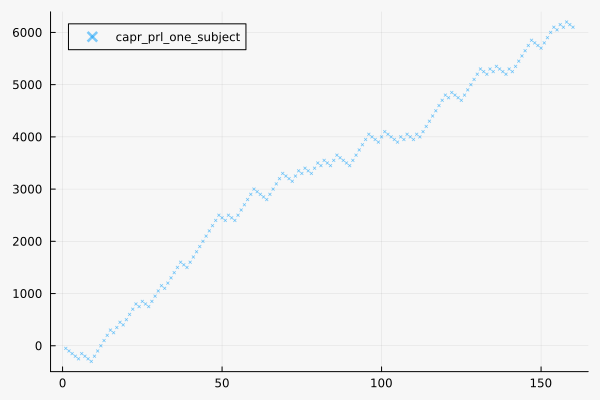

In [3]:
using CSV, DataFrames
# df = CSV.File("data/AAPL.csv") |> DataFrame
# series = df[!, :Open];
# scatter(series, markershape=:xcross, markersize=1.5, markeralpha=0.5, background_color=:grey97, label="APPL")
df = CSV.File("data/capr_prl_one_subject.csv") |> DataFrame
series = df[!, :reward_tally];
scatter(series, markershape=:xcross, markersize=1.5, markeralpha=0.5, background_color=:grey97, label="capr_prl_one_subject")


┌ Info: Saved animation to C:\Users\mkpap\AppData\Local\Temp\jl_puXctcLKRQ.gif
└ @ Plots C:\Users\mkpap\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\mkpap\\AppData\\Local\\Temp\\jl_puXctcLKRQ.gif")
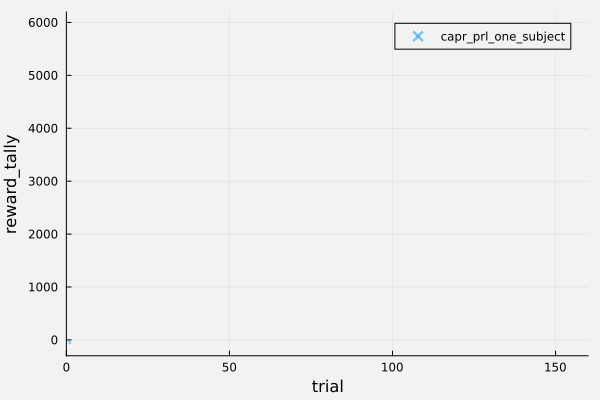

In [4]:
shift = 0.5
@gif for i in 1:length(series)
    scatter(series[1:i], markershape=:xcross, markersize=1.5, markeralpha=0.5, xlim = (0, length(series)), ylim = (minimum(series)-shift, maximum(series)+shift), label="capr_prl_one_subject", xlabel=:trial, ylabel="reward_tally", background_color=:grey95)
end every 1

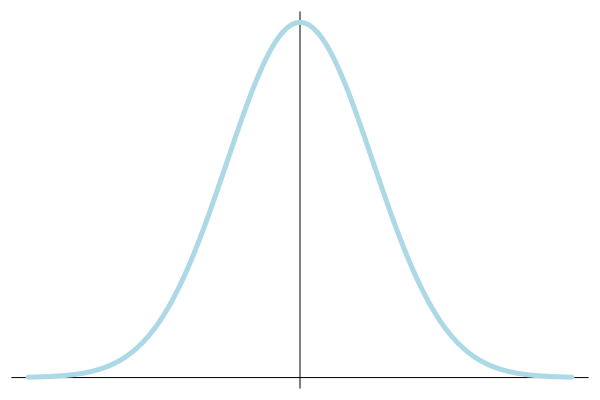

In [5]:
using StatsPlots
import Distributions
normal = Distributions.Normal(0.0, 1.0)
plot(normal, background_color=:transparent, foreground_color=:black, grid=false, ticks = false, legend=false, linewidth=5.0, color=:lightblue, framestyle = :origin)

### 2-L SHGF

In [6]:
# Function for generating 2-L SHGF and message-passing (MP) algorithm
function generate_mp_2l(ndim, n_samples)
    fg = FactorGraph()
    z = Vector{Variable}(undef, n_samples)
    x = Vector{Variable}(undef, n_samples)
    y = Vector{Variable}(undef, n_samples)
    s = Vector{Variable}(undef, n_samples)
    @RV A ~ Dirichlet(ones(ndim, ndim))
    @RV ω ~ GaussianMeanPrecision(placeholder(:mω, dims=(ndim, )), placeholder(:wω, dims=(ndim, ndim)))
    @RV [id=pad(:z,1)] z[1] ~ GaussianMeanPrecision(placeholder(:mz_prior1), placeholder(:wz_prior1))
    @RV [id=pad(:x,1)] x[1] ~ GaussianMeanPrecision(placeholder(:mx_prior1), placeholder(:wx_prior1))
    @RV [id=pad(:y,1)] y[1] ~ GaussianMeanPrecision(x[1], placeholder(:wy_prior1))
    @RV [id=pad(:s,1)] s[1] ~ ForneyLab.Categorical(ones(ndim) ./ ndim)
    placeholder(y[1], :y, index = 1)
    for t in 2:n_samples
        @RV [id=pad(:s,t)] s[t] ~ Transition(s[t-1], A)
        @RV [id=pad(:z,t)] z[t] ~ GaussianMeanPrecision(z[t - 1], placeholder(pad(:wz_transition, t)))
        @RV [id=pad(:x,t)] x[t] ~ SwitchingGaussianControlledVariance(x[t - 1], z[t],ones(ndim), ω,s[t])
        @RV [id=pad(:y,t)] y[t] ~ GaussianMeanPrecision(x[t], placeholder(pad(:wy_transition, t)))
        placeholder(y[t], :y, index = t)
    end
    q = PosteriorFactorization(x, z, ω, s, A, ids=[:X :Z :Ω :S :A])
    algo = messagePassingAlgorithm(free_energy=true)
    src_code = algorithmSourceCode(algo, free_energy=true);
    return src_code
end

# Function for running MP-based inference for 2-L SHGF
function mp_2l(obs;
    ndims,
    n_its = 100,
    wy_prior1 = 1.0,
    κ_m_prior = ones(ndims),
    ω_m_prior = omegas,
    κ_w_prior =  huge .* diageye(ndims),
    ω_w_prior = 1.0 * diageye(ndims),
    z_m_prior = 0.0,
    z_w_prior = 1.0,
    x_m_prior = 0.0,
    x_w_prior = 1.0,
    x_x_m_prior = zeros(ndims),
    x_x_w_prior = 1.0*diageye(ndims),
    z_z_m_prior = zeros(ndims),
    z_z_w_prior = 1.0*diageye(ndims),
    z_w_transition_prior = 100.0,
    y_w_transition_prior =  1/mnv,
)
    n_samples = length(obs)
    marginals = Dict()
    marginals[:A] = ProbabilityDistribution(ForneyLab.MatrixVariate, Dirichlet, a=ones(ndims, ndims))
    marginals[:κ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = κ_m_prior, w = κ_w_prior)
    marginals[:ω] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m = ω_m_prior, w = ω_w_prior)
    marginals[pad(:z,1)] = vague(GaussianMeanPrecision)
    marginals[pad(:x,1)] = vague(GaussianMeanPrecision)
    marginals[pad(:s,1)] = vague(Categorical, ndims)
    for t = 2:n_samples
        marginals[pad(:z,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = z_m_prior, w = z_w_prior)
        marginals[pad(:x,t)] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanPrecision, m = x_m_prior, w = x_w_prior)
        marginals[pad(:s,t)] = ProbabilityDistribution(Categorical, p = ones(ndims) ./ ndims)
        marginals[pad(:s,t)*:_*pad(:s,t-1)] = ProbabilityDistribution(Contingency,p=ones(ndims, ndims) ./ ndims)
        marginals[pad(:z,t)*:_*pad(:z,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = z_z_m_prior, w = z_z_w_prior)
        marginals[pad(:x,t)*:_*pad(:x,t-1)] = ProbabilityDistribution(ForneyLab.Multivariate,GaussianMeanPrecision, m = x_x_m_prior, w = x_x_w_prior)
    end
    data = Dict()
    data[:y] = obs
    data[:mz_prior1] = z_m_prior
    data[:wz_prior1] = z_w_prior
    data[:mx_prior1] = x_m_prior
    data[:wx_prior1] = x_w_prior
    data[:wy_prior1] = wy_prior1
    data[:mω] = ω_m_prior
    data[:wω] = ω_w_prior
    for t = 1:n_samples
        data[pad(:wz_transition, t)] = z_w_transition_prior
        data[pad(:wy_transition, t)] = y_w_transition_prior
    end


    fe = Vector{Float64}(undef, n_its)

    @showprogress "Iterations" for i = 1:n_its

        stepX!(data, marginals)
        stepS!(data, marginals)
        stepA!(data, marginals)
        stepΩ!(data, marginals)
        stepZ!(data, marginals)

        fe[i] = freeEnergy(data, marginals)
    end

    mz = [ForneyLab.unsafeMean(marginals[pad(:z,t)]) for t=1:n_samples]
    vz = [ForneyLab.unsafeVar(marginals[pad(:z,t)]) for t=1:n_samples]
    mω = ForneyLab.unsafeMean(marginals[:ω])
    vω = ForneyLab.unsafeCov(marginals[:ω])
    mx = [ForneyLab.unsafeMean(marginals[pad(:x,t)]) for t=1:n_samples]
    vx = [ForneyLab.unsafeVar(marginals[pad(:x,t)]) for t=1:n_samples]
    ms = [ForneyLab.unsafeMean(marginals[pad(:s,t)]) for t=1:n_samples]
    return mz,vz,mω, vω, mx,vx,ms,fe
end

mp_2l (generic function with 1 method)

In [7]:
# Empirically selected prior [-8, 8]
# og_priors from hgf: -2,2 and 1,1
# Rosa's: 1,1 and 1,1
# Praveen's: -2,-2 and 1,1
omegas = [0, 3]

2-element Vector{Int64}:
 0
 3

In [8]:
n_cats = length(omegas)
code = generate_mp_2l(n_cats, length(series))
eval(Meta.parse(code))

freeEnergy (generic function with 1 method)

In [9]:
mz,vz,mω, vω, mx,vx,ms,fe = mp_2l(series, x_m_prior=series[1], ndims=n_cats, z_w_prior=100.0, z_z_w_prior=100.0*diageye(2), z_w_transition_prior=100.0, ω_m_prior=omegas, ω_w_prior=diageye(2), y_w_transition_prior=1e6)

results =   Dict("mz" => mz, "vz" => vz,
                  "mx" => mx, "vx" => vx,
                  "ms" => ms, "fe" => fe,
                  "mω" => mω, "vω" => vω,
                  "ωprior" => omegas)

Iterations   2%|█                                        |  ETA: 0:09:05

Iterations   6%|███                                      |  ETA: 0:03:08

Iterations   7%|███                                      |  ETA: 0:02:41

Iterations   8%|████                                     |  ETA: 0:02:21

Iterations   9%|████                                     |  ETA: 0:02:05

Iterations  10%|█████                                    |  ETA: 0:01:53

Iterations  11%|█████                                    |  ETA: 0:01:42

Iterations  12%|█████                                    |  ETA: 0:01:34

Iterations  13%|██████                                   |  ETA: 0:01:26

Iterations  14%|██████                                   |  ETA: 0:01:20

Iterations  15%|███████                                  |  ETA: 0:01:14

Iterations  16%|███████                                  |  ETA: 0:01:10

Iterations  17%|███████                                  |  ETA: 0:01:05

Iterations  18%|████████                                 |  ETA: 0:01:02

Iterations  19%|████████                                 |  ETA: 0:00:58

Iterations  20%|█████████                                |  ETA: 0:00:55

Iterations  21%|█████████                                |  ETA: 0:00:52

Iterations  22%|██████████                               |  ETA: 0:00:50

Iterations  23%|██████████                               |  ETA: 0:00:48

Iterations  24%|██████████                               |  ETA: 0:00:45

Iterations  25%|███████████                              |  ETA: 0:00:43

Iterations  26%|███████████                              |  ETA: 0:00:42

Iterations  27%|████████████                             |  ETA: 0:00:40

Iterations  28%|████████████                             |  ETA: 0:00:38

Iterations  29%|████████████                             |  ETA: 0:00:37

Iterations  30%|█████████████                            |  ETA: 0:00:35

Iterations  31%|█████████████                            |  ETA: 0:00:34

Iterations  32%|██████████████                           |  ETA: 0:00:33

Iterations  33%|██████████████                           |  ETA: 0:00:32

Iterations  34%|██████████████                           |  ETA: 0:00:30

Iterations  35%|███████████████                          |  ETA: 0:00:29

Iterations  36%|███████████████                          |  ETA: 0:00:28

Iterations  37%|████████████████                         |  ETA: 0:00:27

Iterations  38%|████████████████                         |  ETA: 0:00:26

Iterations  39%|████████████████                         |  ETA: 0:00:25

Iterations  40%|█████████████████                        |  ETA: 0:00:25

Iterations  41%|█████████████████                        |  ETA: 0:00:24

Iterations  42%|██████████████████                       |  ETA: 0:00:23

Iterations  43%|██████████████████                       |  ETA: 0:00:22

Iterations  44%|███████████████████                      |  ETA: 0:00:22

Iterations  45%|███████████████████                      |  ETA: 0:00:21

Iterations  46%|███████████████████                      |  ETA: 0:00:20

Iterations  47%|████████████████████                     |  ETA: 0:00:20

Iterations  48%|████████████████████                     |  ETA: 0:00:19

Iterations  49%|█████████████████████                    |  ETA: 0:00:18

Iterations  50%|█████████████████████                    |  ETA: 0:00:18

Iterations  51%|█████████████████████                    |  ETA: 0:00:17

Iterations  52%|██████████████████████                   |  ETA: 0:00:17

Iterations  53%|██████████████████████                   |  ETA: 0:00:16

Iterations  54%|███████████████████████                  |  ETA: 0:00:16

Iterations  55%|███████████████████████                  |  ETA: 0:00:15

Iterations  56%|███████████████████████                  |  ETA: 0:00:15

Iterations  57%|████████████████████████                 |  ETA: 0:00:14

Iterations  58%|████████████████████████                 |  ETA: 0:00:14

Iterations  59%|█████████████████████████                |  ETA: 0:00:13

Iterations  60%|█████████████████████████                |  ETA: 0:00:13

Iterations  61%|██████████████████████████               |  ETA: 0:00:12

Iterations  62%|██████████████████████████               |  ETA: 0:00:12

Iterations  63%|██████████████████████████               |  ETA: 0:00:11

Iterations  64%|███████████████████████████              |  ETA: 0:00:11

Iterations  65%|███████████████████████████              |  ETA: 0:00:11

Iterations  66%|████████████████████████████             |  ETA: 0:00:10

Iterations  67%|████████████████████████████             |  ETA: 0:00:10

Iterations  68%|████████████████████████████             |  ETA: 0:00:10

Iterations  69%|█████████████████████████████            |  ETA: 0:00:09

Iterations  70%|█████████████████████████████            |  ETA: 0:00:09

Iterations  71%|██████████████████████████████           |  ETA: 0:00:09

Iterations  72%|██████████████████████████████           |  ETA: 0:00:08

Iterations  73%|██████████████████████████████           |  ETA: 0:00:08

Iterations  74%|███████████████████████████████          |  ETA: 0:00:08

Iterations  75%|███████████████████████████████          |  ETA: 0:00:07

Iterations  76%|████████████████████████████████         |  ETA: 0:00:07

Iterations  77%|████████████████████████████████         |  ETA: 0:00:07

Iterations  78%|████████████████████████████████         |  ETA: 0:00:06

Iterations  79%|█████████████████████████████████        |  ETA: 0:00:06

Iterations  80%|█████████████████████████████████        |  ETA: 0:00:06

Iterations  81%|██████████████████████████████████       |  ETA: 0:00:05

Iterations  82%|██████████████████████████████████       |  ETA: 0:00:05

Iterations  83%|███████████████████████████████████      |  ETA: 0:00:05

Iterations  84%|███████████████████████████████████      |  ETA: 0:00:04

Iterations  85%|███████████████████████████████████      |  ETA: 0:00:04

Iterations  86%|████████████████████████████████████     |  ETA: 0:00:04

Iterations  88%|█████████████████████████████████████    |  ETA: 0:00:03

Iterations  89%|█████████████████████████████████████    |  ETA: 0:00:03

Iterations  90%|█████████████████████████████████████    |  ETA: 0:00:03

Iterations  92%|██████████████████████████████████████   |  ETA: 0:00:02

Iterations  93%|███████████████████████████████████████  |  ETA: 0:00:02

Iterations  94%|███████████████████████████████████████  |  ETA: 0:00:02

Iterations  95%|███████████████████████████████████████  |  ETA: 0:00:01

Iterations  96%|████████████████████████████████████████ |  ETA: 0:00:01

Iterations  97%|████████████████████████████████████████ |  ETA: 0:00:01

Iterations  98%|█████████████████████████████████████████|  ETA: 0:00:01

Iterations  99%|█████████████████████████████████████████|  ETA: 0:00:00

Iterations 100%|█████████████████████████████████████████| Time: 0:00:24


Dict{String, Array} with 9 entries:
  "vx"     => [0.499961, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6, 1.0e-6…
  "vω"     => [0.999999 -0.0; -0.0 0.011591]
  "mz"     => [0.000814956, 0.00162991, 0.00509209, 0.0114189, 0.0206842, 0.032…
  "mx"     => [-50.0039, -100.0, -150.0, -200.0, -250.0, -150.0, -200.0, -250.0…
  "ms"     => [[0.320612, 0.679388], [1.21072e-12, 1.0], [1.00353e-12, 1.0], [1…
  "fe"     => [1189.46, 959.317, 959.316, 959.316, 959.316, 959.316, 959.316, 9…
  "mω"     => [1.48851e-7, 8.77407]
  "vz"     => [0.00945722, 0.0178289, 0.025208, 0.031642, 0.0371672, 0.0418101,…
  "ωprior" => [0, 3]

In [10]:
mω

2-element Vector{Float64}:
 1.4885082930392614e-7
 8.774073363320232

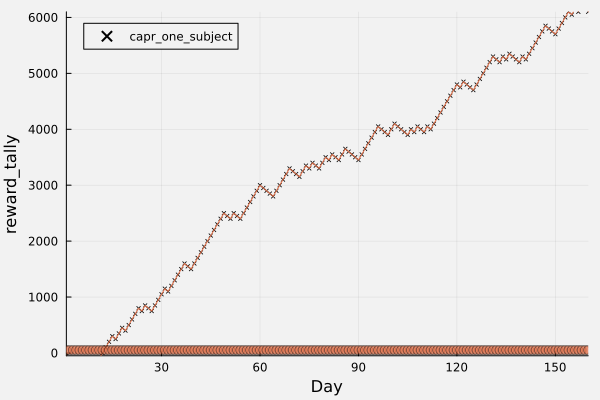

In [11]:
xlims_ = 1, length(series)
switch_line = 52
shift = 0.05
scatter(series, background_color=:grey95, xlabel=:Day, ylabel="reward_tally", label="capr_one_subject", markershape=:xcross, markersize=2, markeralpha=1.0, color=:black)
plot!(mx, ribbon=sqrt.(vx), label=false)
scatter!(switch_line*ones(length(ms)), color=argmax.(ms), markersize=5.0, markeralpha=0.5, label=false)
xlims!(xlims_)
ylims!(mx[xlims_[1]]-shift, mx[xlims_[2]]+shift)

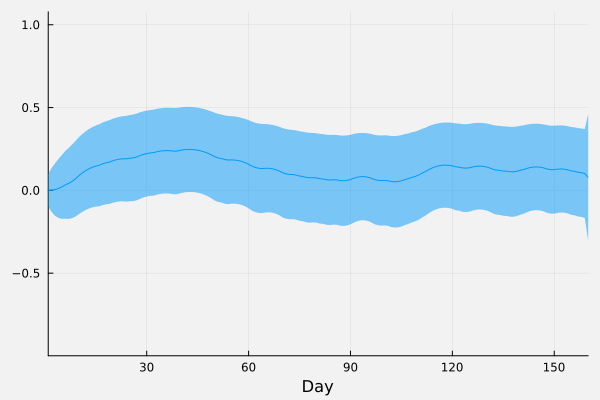

In [12]:
shift = 1.0
plot(mz, ribbon=sqrt.(vz), label=false, xlim = (0, length(series)), ylim = (minimum(mz)-shift, maximum(mz)+shift) ,background_color=:grey95, xlabel=:Day)
xlims!(xlims_)
ylims!(mz[xlims_[1]]-shift, mz[xlims_[2]]+shift)

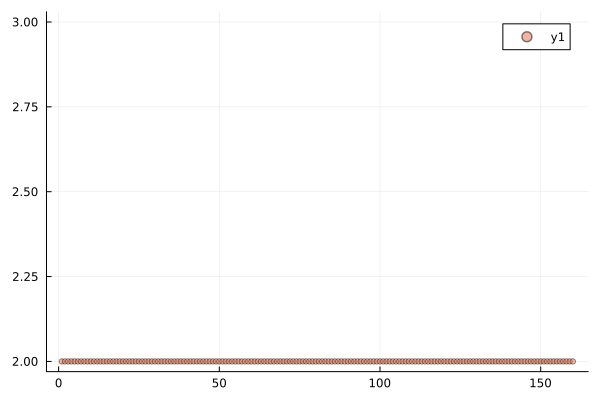

In [13]:
scatter(argmax.(ms), color=argmax.(ms), markersize=3.0, markeralpha=0.5)

┌ Info: Saved animation to C:\Users\mkpap\AppData\Local\Temp\jl_JQdwvm3CDO.gif
└ @ Plots C:\Users\mkpap\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\mkpap\\AppData\\Local\\Temp\\jl_JQdwvm3CDO.gif")
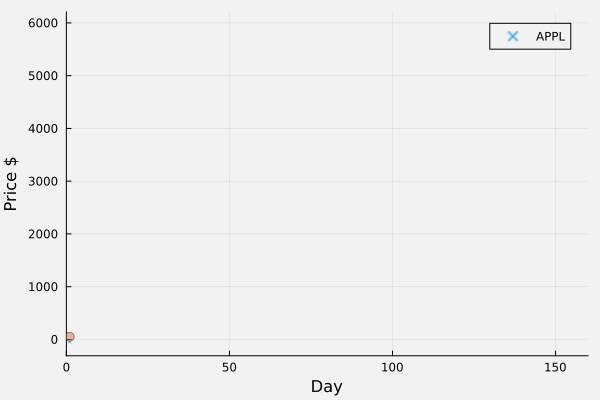

In [14]:
shift = 10
@gif for i in 1:length(series)
    scatter(series[1:i], markershape=:xcross, markersize=1.5, markeralpha=0.5, xlim = (0, length(series)), ylim = (minimum(series)-shift, maximum(series)+shift), label="APPL", xlabel=:Day, ylabel="Price \$", background_color=:grey95)
    scatter!(50*ones(length(ms[1:i])), color=argmax.(ms[1:i]), markersize=5.0, markeralpha=0.5, label=false)    
    plot!(mx[1:i], ribbon=sqrt.(vx[1:i]), label=false)
end every 1

┌ Info: Saved animation to C:\Users\mkpap\AppData\Local\Temp\jl_dKJMtQ9cLY.gif
└ @ Plots C:\Users\mkpap\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\mkpap\\AppData\\Local\\Temp\\jl_dKJMtQ9cLY.gif")
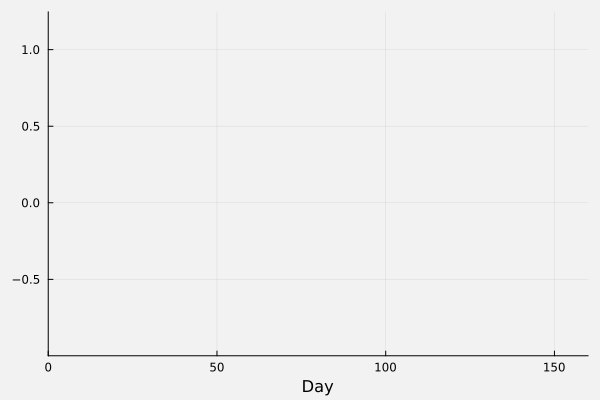

In [15]:
shift = 1
@gif for i in 1:length(series)
    plot(mz[1:i], ribbon=sqrt.(vz[1:i]), label=false, xlim = (0, length(series)), ylim = (minimum(mz)-shift, maximum(mz)+shift) ,background_color=:grey95, xlabel=:Day)
end every 1

In [16]:
using JLD
JLD.save("dump/results_2shgf_stocks_mixture.jld","results",results)